imports

In [1]:
import csv
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)

from sklearn.cluster import KMeans

def plotImage(matrix):  # appropriate for weights
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.ocean,
        extent=[matrix.min(), matrix.max(), matrix[0].min(), matrix[0].max()])
    plt.colorbar()
    plt.show()

function for reading feature extracted file and clustering

In [2]:
def import_features(features_file_path, labels_file_path):
    with open(features_file_path, 'rb') as f:
        reader = csv.reader(f, delimiter=',')
        mylist = list(reader)
        data = np.asanyarray(mylist).astype(float)
    labels = []
    with open(labels_file_path,'rU') as f:
        rows = csv.DictReader(f)
        for row in rows:
            labels.append(row['Class'])
    labels = np.asarray(labels).astype(int)
    return (data,labels)

loading features and applying differnet methods

In [6]:
#(data,labels) = import_features("features/synthetic/pool_3:0.csv", "datasets/synthetic/trainLabels.csv")
(data,labels) = import_features("features/images/pool_3:0.csv", "datasets/images/trainLabels.csv")

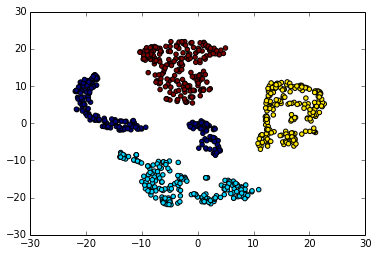

In [7]:
# T-SNE
points = tsne_model.fit_transform(data)
plt.scatter(points[:,0],points[:,1], c=labels)

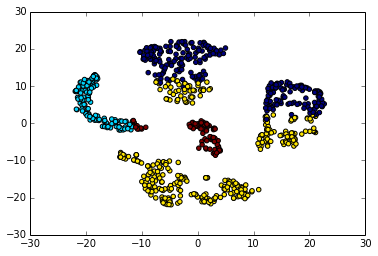

In [8]:
# K-Means
kmeans_model = KMeans(n_clusters=4, random_state=1).fit(data)
plt.scatter(points[:,0],points[:,1], c=kmeans_model.labels_)
plt.show()

In [ ]:
#import seaborn as sns
#x = points[:,0]
#y = points[:,1]
#sns.regplot(x,y)